In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [2]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: levenshtein
    Found existing installation: Levenshtein 0.20.7
    Uninstalling Levenshtein-0.20.7:
      Successfully uninstalled Levenshtein-0.20.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-levenshtein 0.20.7 requires Levenshtein==0.20.7, but you have levenshtein 0.20.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model, Model
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
tqdm.pandas()
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
from jiwer import wer, mer, cer, wip, wil

In [4]:
plt.rcParams['figure.figsize'] = (12,8)

In [5]:
df = pd.read_csv('../input/news-summary/news_summary_more.csv')
df = df.sample(n=8000).reset_index(drop=True)
df.head()

,headlines,text
0,Non-Congress candidate for Prez would've been ...,All India Majlis-e-Ittehadul Muslimeen (AIMIM)...
1,"If Nana was common man, he'd be immediately ar...",Tanushree Dutta's lawyer N Satpute has said if...
2,Irma world's longest storm to bear 185 mph win...,Hurricane Irma has become the world's longest ...
3,"Best ideas born on campuses, not fancy offices...",Addressing students at IIT Bombay's convocatio...
4,Former UP CM Akhilesh Yadav bans media from ne...,Interacting with the media during Eid celebrat...


In [6]:
df.shape

(8000, 2)

In [7]:
df.isna().sum()

headlines    0
text         0
dtype: int64

In [8]:
df = df.dropna()
df.shape

(8000, 2)

In [9]:
df.duplicated().sum()

0

In [10]:
df = df.drop_duplicates()
df.shape

(8000, 2)

In [11]:
df['text_len'] = df.text.apply(len)
df['headlines_len'] = df.headlines.apply(len)

<AxesSubplot:xlabel='headlines_len', ylabel='Density'>

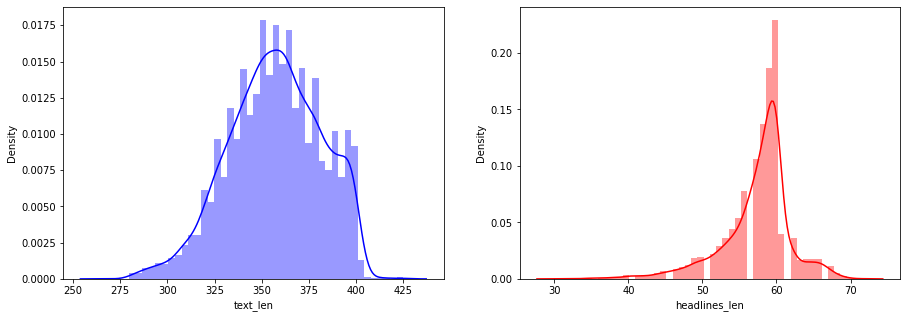

In [12]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.distplot(df.text_len,ax=axes[0],color='blue')
sns.distplot(df.headlines_len,ax=axes[1],color='red')

In [13]:
df.describe()

,text_len,headlines_len
count,8000.000000,8000.000000
mean,356.952375,57.383375
std,24.393359,4.730428
min,266.000000,30.000000
25%,340.000000,56.000000
50%,357.000000,58.000000
75%,375.000000,60.000000
max,425.000000,72.000000


In [14]:
max_text_len = 350
max_headline_len = 50

In [15]:
df.headlines = df.headlines.apply(lambda x: '<START> ' + x + ' <END>')

In [16]:
def clean_text(text):
    text = text.lower().strip()
    # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    text_decontracted = []

    for word in text.split():
        if word in contractions:
            word = contractions[word]

        text_decontracted.append(word)
        
    text = ' '.join(text_decontracted)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")        
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()
    return text

In [17]:
df.text = df.text.progress_apply(clean_text)
df.headlines = df.headlines.progress_apply(clean_text)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [18]:
df.head()

,headlines,text,text_len,headlines_len
0,start noncongress candidate for prez would hav...,all india majliseittehadul muslimeen aimim pre...,384,60
1,start if nana was common man he would be immed...,tanushree dutta s lawyer n satpute has said if...,342,60
2,start irma world s longest storm to bear 185 m...,hurricane irma has become the world s longest ...,325,58
3,start best ideas born on campuses not fancy of...,addressing students at iit bombay s convocatio...,343,57
4,start former up cm akhilesh yadav bans media f...,interacting with the media during eid celebrat...,379,57


In [19]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(df.text)

In [20]:
text_vocab_length = len(x_tokenizer.index_word) + 1
text_vocab_length

32583

In [21]:
text_sequences = x_tokenizer.texts_to_sequences(df.text)
text_pad_sequences = pad_sequences(text_sequences,maxlen=max_text_len,padding='post')

In [22]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(df.headlines)

In [23]:
headline_vocab_length = len(y_tokenizer.index_word) + 1
headline_vocab_length

13451

In [24]:
headline_sequences = y_tokenizer.texts_to_sequences(df.headlines)
headline_pad_sequences = pad_sequences(headline_sequences,maxlen=max_headline_len,padding='post')

In [25]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [26]:
K.clear_session()

latent_dim = 300 
embedding_dim = 100 

encoder_inputs = Input(shape=(max_text_len,))
encoder_emb = Embedding(text_vocab_length, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_output2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(headline_vocab_length, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 

attn_layer = AttentionLayer(name='attention_layer') 
attn_outputs, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

decoder_dense = TimeDistributed(Dense(headline_vocab_length,activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

2022-10-31 08:55:12.211120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 08:55:12.212230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 08:55:12.383059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 08:55:12.384114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 08:55:12.384962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 100)     3258300     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 350, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

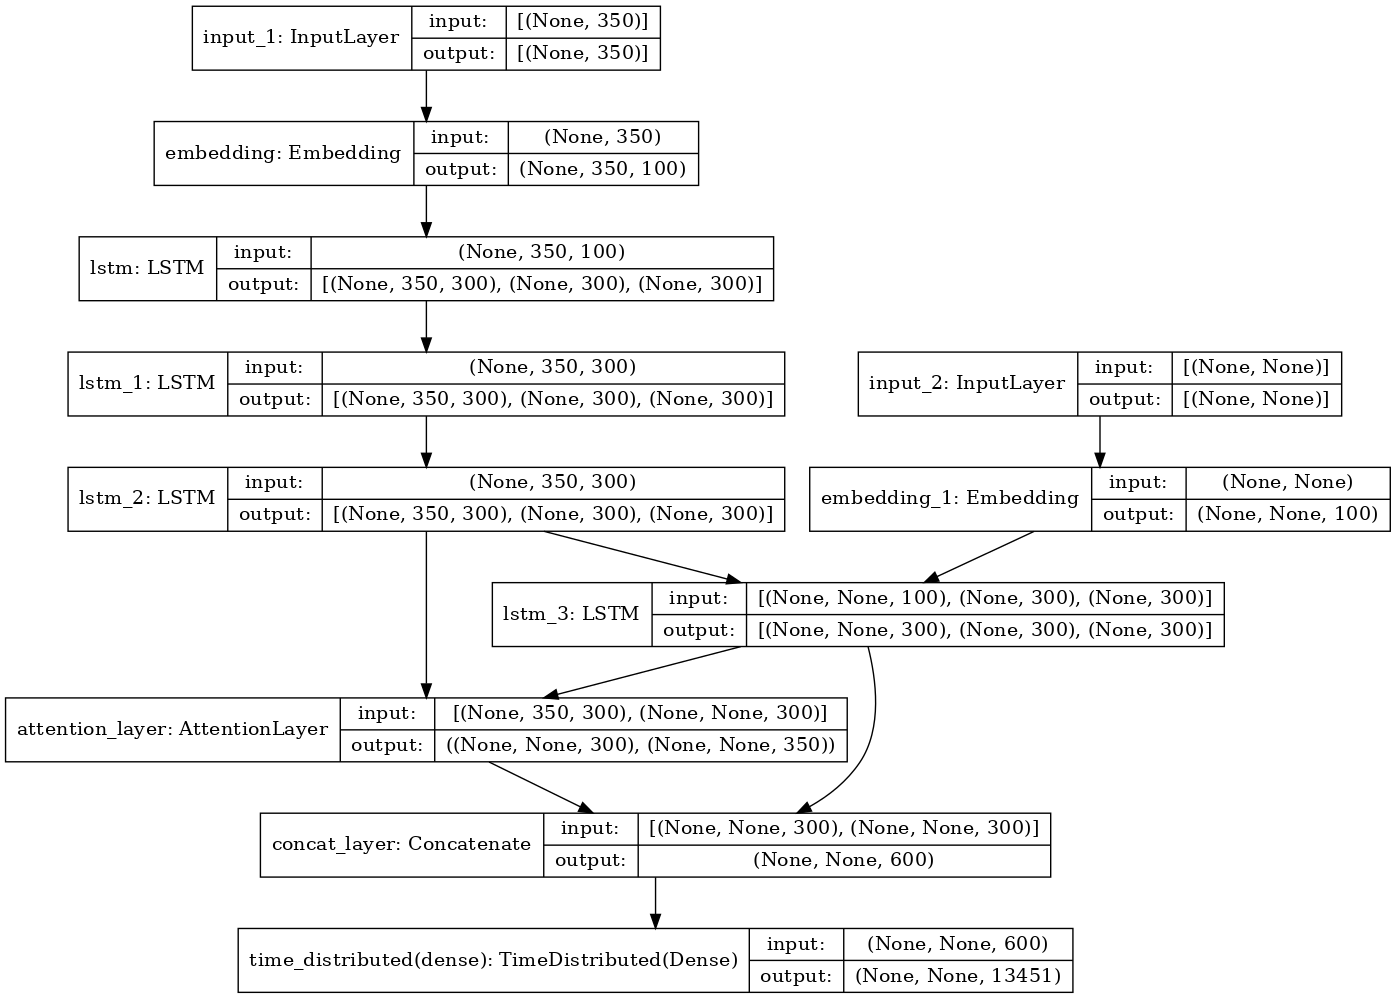

In [27]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [28]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(text_pad_sequences,headline_pad_sequences,test_size=0.25,shuffle=True,random_state=101)

In [30]:
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

r = model.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=50,
             batch_size=128,
             callbacks=[es,rl,mc],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

2022-10-31 08:55:19.124336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
47/47 [==============================] - 346s 7s/step - loss: 2.2529 - accuracy: 0.7644 - val_loss: 1.7169 - val_accuracy: 0.7846

Epoch 00001: val_accuracy improved from -inf to 0.78456, saving model to checkpoint/


2022-10-31 09:01:08.568114: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
47/47 [==============================] - 337s 7s/step - loss: 1.6782 - accuracy: 0.7900 - val_loss: 1.6979 - val_accuracy: 0.8024

Epoch 00002: val_accuracy improved from 0.78456 to 0.80239, saving model to checkpoint/
Epoch 3/50
47/47 [==============================] - 333s 7s/step - loss: 1.6141 - accuracy: 0.8029 - val_loss: 1.6856 - val_accuracy: 0.8035

Epoch 00003: val_accuracy improved from 0.80239 to 0.80350, saving model to checkpoint/
Epoch 4/50
47/47 [==============================] - 343s 7s/step - loss: 1.5750 - accuracy: 0.8041 - val_loss: 1.6541 - val_accuracy: 0.8041

Epoch 00004: val_accuracy improved from 0.80350 to 0.80410, saving model to checkpoint/
Epoch 5/50
47/47 [==============================] - 325s 7s/step - loss: 1.5370 - accuracy: 0.8045 - val_loss: 1.6401 - val_accuracy: 0.8044

Epoch 00005: val_accuracy improved from 0.80410 to 0.80441, saving model to checkpoint/
Epoch 6/50
47/47 [==============================] - 318s 7s/step - loss: 1.5064 

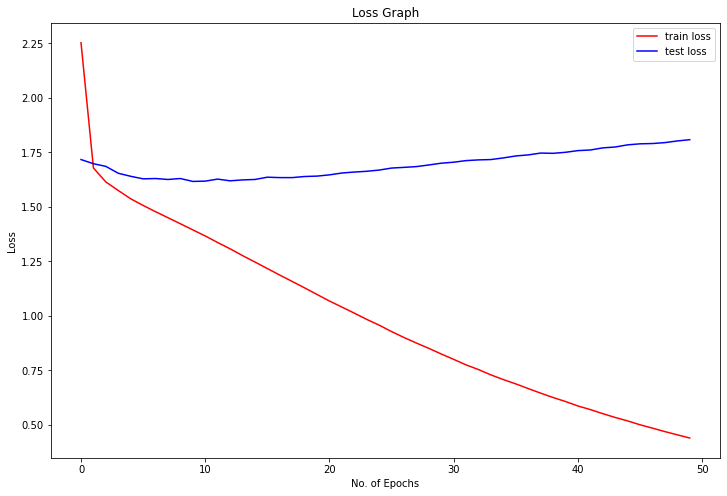

In [31]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

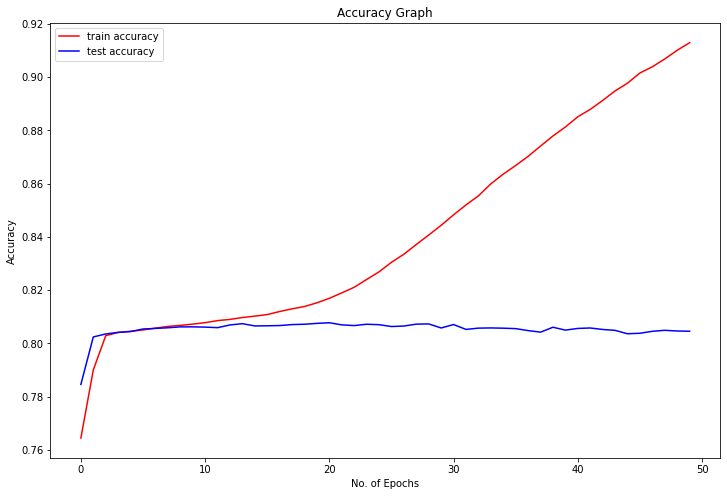

In [32]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [33]:
model.evaluate([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:])

63/63 [==============================] - 34s 533ms/step - loss: 1.8080 - accuracy: 0.8045


[1.8080321550369263, 0.8045306205749512]

In [34]:
model.save('news_article_summary_generator.h5')

In [35]:
lm = load_model('news_article_summary_generator.h5',custom_objects={'AttentionLayer': AttentionLayer})
lm

In [36]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_text_len, latent_dim))

decoder_out, decoder_state_a, decoder_state_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat_outputs = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat_outputs)
decoder_model = Model([decoder_inputs]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_state_a, decoder_state_c])

In [37]:
def decode_sequences(input_sequence):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_sequence)
    next_input = np.zeros((1,1))
    next_input[0,0] = y_tokenizer.word_index['start']
    output_sequence = ''
    stop = False
    while not stop:
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        output_idx = np.argmax(decoded_out[0, -1, :])
        if output_idx == y_tokenizer.word_index['end']: 
            stop = True
        elif output_idx > 0 and output_idx != y_tokenizer.word_index['start']:
            output_token = y_tokenizer.index_word[output_idx] 
            output_sequence = output_sequence + ' ' + output_token 
        next_input[0,0] = output_idx
        # Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_sequence     

In [38]:
def sequence_to_text(input_sequence,mode):
    res = ''
    
    if mode == 'input':
        for idx in input_sequence:
            if idx:
                res = res + x_tokenizer.index_word[idx] + ' '
    
    elif mode == 'output':
        for idx in input_sequence:
            if idx:
                if y_tokenizer.index_word[idx] != 'start' and y_tokenizer.index_word[idx] != 'end':
                    res = res + y_tokenizer.index_word[idx] + ' '
    
    return res

In [39]:
predicted_summaries = []

for i in range(20):
    print("News Article:",sequence_to_text(X_test[i],'input'))
    print("Original Article Summary:",sequence_to_text(y_test[i],'output'))
    pred_summary = decode_sequences(X_test[i].reshape(1,max_text_len))
    print("Predicted Article Summary:",pred_summary)
    predicted_summaries.append(pred_summary)
    print()
    print('---------------------------')
    print()

News Article: us president donald trump on tuesday said that fresh sanctions on north korea approved by the un security council were just a small step and nothing compared to what ultimately will have to happen i do not know if it has any impact but certainly it was nice to get a 15 to nothing vote trump added 
Original Article Summary: n korea sanctions nothing compared to what will happen trump 
Predicted Article Summary:  trump contradicts tweeting to cherish hafiz saeed us

---------------------------

News Article: the mayor of the us town of hell elijah daniel was impeached on wednesday just three hours after he took office for declaring heterosexuality as illegal my ban is a copyandpaste of trump s muslim ban but with heterosexuals instead the 23yearold said interestingly he had become the mayor by giving town organisers a small fee 
Original Article Summary: mayor of us town hell impeached for banning heterosexuals 
Predicted Article Summary:  railways of bosnia gets others for

In [40]:
original_summaries = []
references = []

for i in range(20):
    original_summaries.append(sequence_to_text(y_test[i],'output'))

for summary in original_summaries:
    ref = ' '.join(summary.split())
    references.append(ref)

In [41]:
for i in range(20):
    print("Original News Article Summary:",references[i])
    print("Predicted News Article Summary:",predicted_summaries[i])
    print("BLEU Score:",sentence_bleu(references[i],predicted_summaries[i],weights=(0.25,0.25,0.25,0.25)))
    print("Word Error Rate:",wer(references[i],predicted_summaries[i]))
    print("Match Error Rate:",mer(references[i],predicted_summaries[i]))
    print("Character Error Rate:",cer(references[i],predicted_summaries[i]))
    print("Word Information Preserved:",wip(references[i],predicted_summaries[i]))
    print("Word Information Lost:",wil(references[i],predicted_summaries[i]))
    print('------------------------------------------------------')

Original News Article Summary: n korea sanctions nothing compared to what will happen trump
Predicted News Article Summary:  trump contradicts tweeting to cherish hafiz saeed us
BLEU Score: 1.371044612342374e-231
Word Error Rate: 0.9
Match Error Rate: 0.9
Character Error Rate: 0.7166666666666667
Word Information Preserved: 0.0125
Word Information Lost: 0.9875
------------------------------------------------------
Original News Article Summary: mayor of us town hell impeached for banning heterosexuals
Predicted News Article Summary:  railways of bosnia gets others for eid violence in genocide
BLEU Score: 1.3483065280626046e-231
Word Error Rate: 1.0
Match Error Rate: 0.9
Character Error Rate: 0.7894736842105263
Word Information Preserved: 0.011111111111111112
Word Information Lost: 0.9888888888888889
------------------------------------------------------
Original News Article Summary: how did air force help fight the over 17hour delhi fire
Predicted News Article Summary:  salman signs to